In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyspedas
import pytplot
import datetime
from pytplot import tplot, get_data
from scipy import stats, interpolate, integrate
from astropy import units, constants
pyspedas.version()

02-Sep-25 14:30:34: pyspedas version: 1.7.20


In [2]:
# minimum variance with magnetic field time series
# B1, B2, B3 are three component
def mva_ts(B1, B2, B3):
    B1m = np.nanmean(B1)
    B2m = np.nanmean(B2)
    B3m = np.nanmean(B3)
    MagMat = np.array([[np.nanmean(B1*B1) - B1m**2, np.nanmean(B1*B2) - B1m*B2m, np.nanmean(B1*B3) - B1m*B3m],
                       [np.nanmean(B2*B1) - B2m*B1m, np.nanmean(B2*B2) - B2m**2, np.nanmean(B2*B3) - B2m*B3m],
                       [np.nanmean(B3*B1) - B3m*B1m, np.nanmean(B3*B2) - B3m*B2m, np.nanmean(B3*B3) - B3m**2]])
    vals, vecs = np.linalg.eig(MagMat)
    inds = np.argsort(abs(vals))
    vn = vecs[:,inds[0]]
    vm = vecs[:,inds[1]]
    vl = vecs[:,inds[2]]
    print(vals[inds], np.array([vn, vm, vl]))
    return vl, vm, vn

# compute normal with cross product
def vnormc(B_pre, B_post):
    nc = np.cross(B_pre, B_post)
    nc = nc / np.sqrt(np.sum(nc**2))
    cth = np.dot(B_pre, B_post)/np.sqrt(np.sum(B_pre**2)*np.sum(B_post**2))
    theta = np.arccos(cth)/np.pi*180
    return nc, theta

# hybrid LMN vectors using MVA vectors and cross product normal
def hyb_lmn(vl, vm, vn, vnc):
    vnh = np.copy(vnc)
    vmh = np.cross(vnc, vl)
    vmh = vmh / np.sqrt(np.sum(vmh**2))
    vlh = np.cross(vmh, vnh)
    vlh = vlh / np.sqrt(np.sum(vlh**2))
    return vlh, vmh, vnh

02-Sep-25 14:31:11: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/
02-Sep-25 14:31:11: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19980403_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19980403_v01.cdf
02-Sep-25 14:31:12: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19980403_v01.cdf


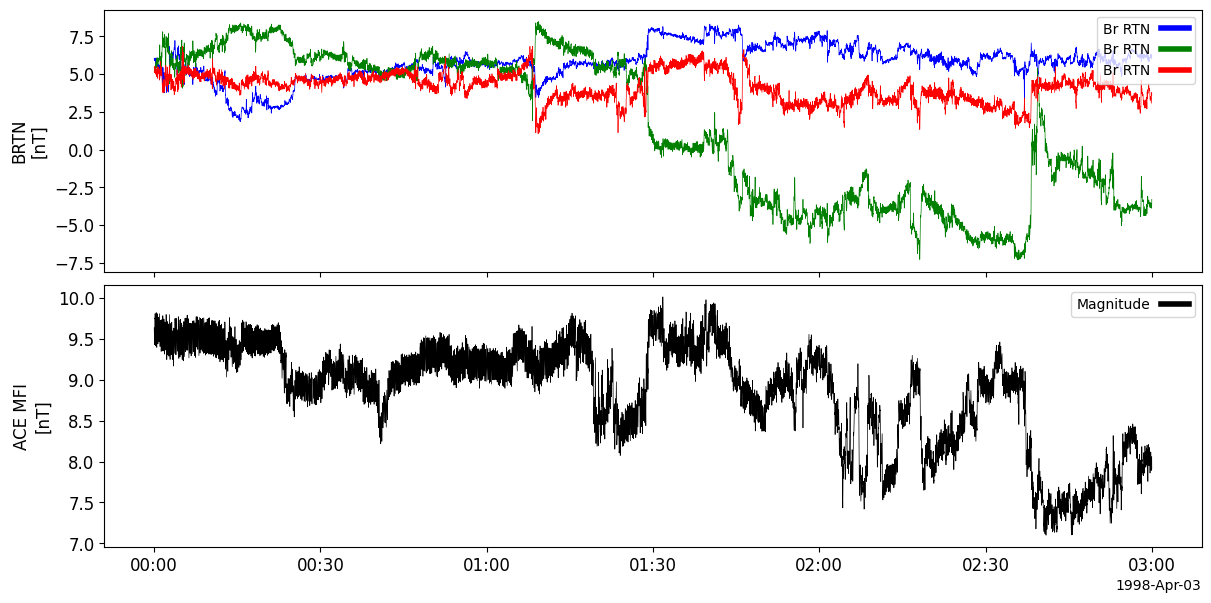

In [3]:
# ACE event 1
Event_number = 1
starttime = "1998-4-3/00:00"
endtime = "1998-4-3/03:00"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:31:21: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/
02-Sep-25 14:31:21: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19980403_v06.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19980403_v06.cdf
02-Sep-25 14:31:21: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19980403_v06.cdf


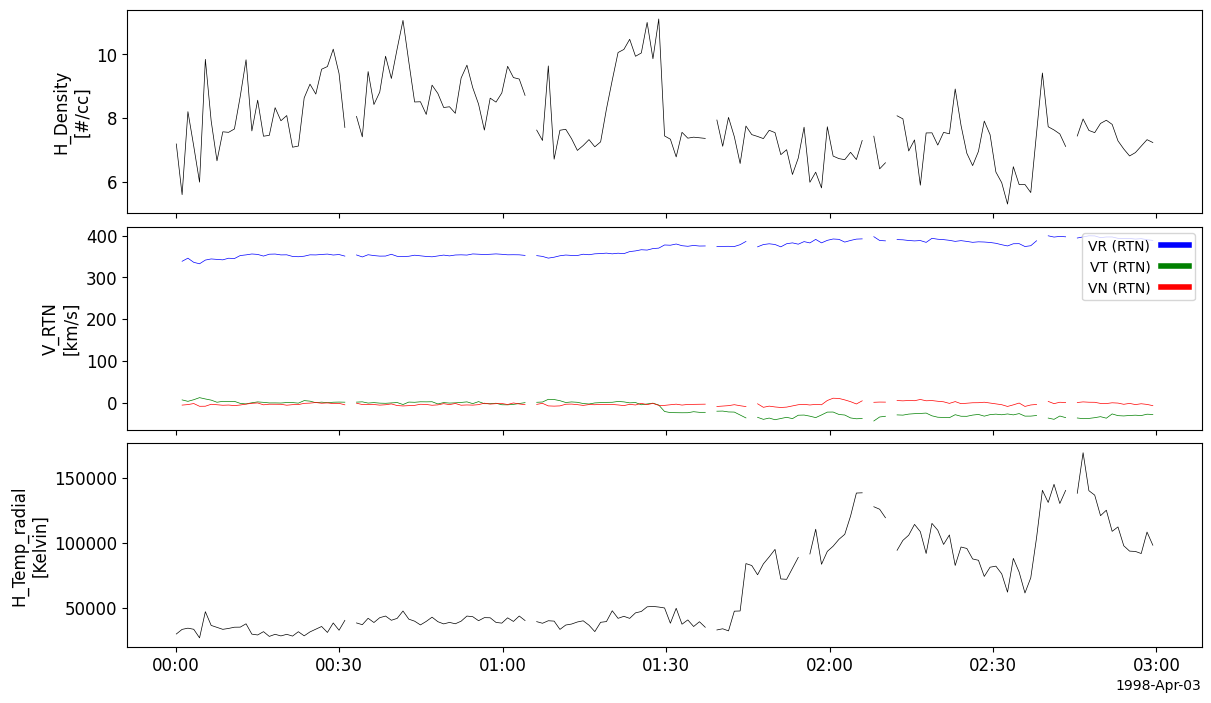

In [4]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
tplot(['Np', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

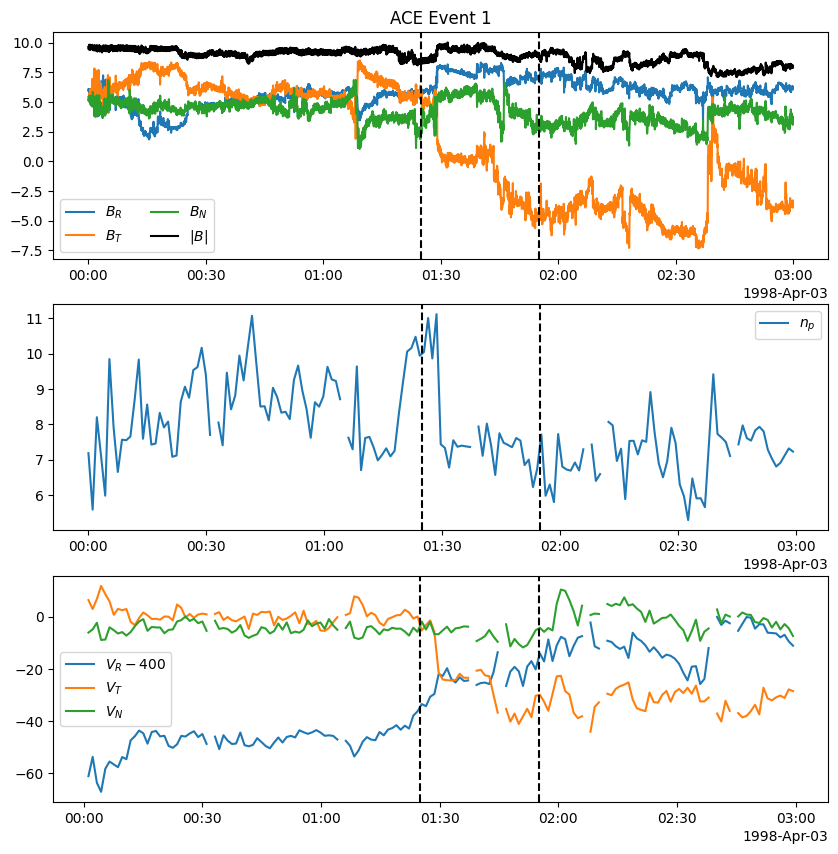

In [5]:
# HCS boundary times
B1_datetime = datetime.datetime(1998, 4, 3, 1, 25, 0)
B2_datetime = datetime.datetime(1998, 4, 3, 1, 55, 0)

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-400, label=r'$V_R-400$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [6]:
# Estimate two-sided upstream averages with 30-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=30)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=30)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = Bmag1.mean()

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = Bmag2.mean()

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('Np', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  9.149232 8.477946
n_proton (/cc):  8.388137 7.1213584
V_r (km/s):  354.9588 389.17154
|V| (km/s):  355.00876 390.52017


In [7]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[ 0.30151735  1.33763458 20.38214101] [[ 0.87533498  0.12100147 -0.46813173]
 [ 0.46863501  0.02604426  0.88300789]
 [-0.11903739  0.99231061  0.03390807]]
[[-0.12506319  0.99116814  0.04410117]
 [ 0.85353401  0.08482303  0.51408632]
 [ 0.50580519  0.10193513 -0.85660398]] 69.91988838242266


Text(0, 0.5, 'km/s')

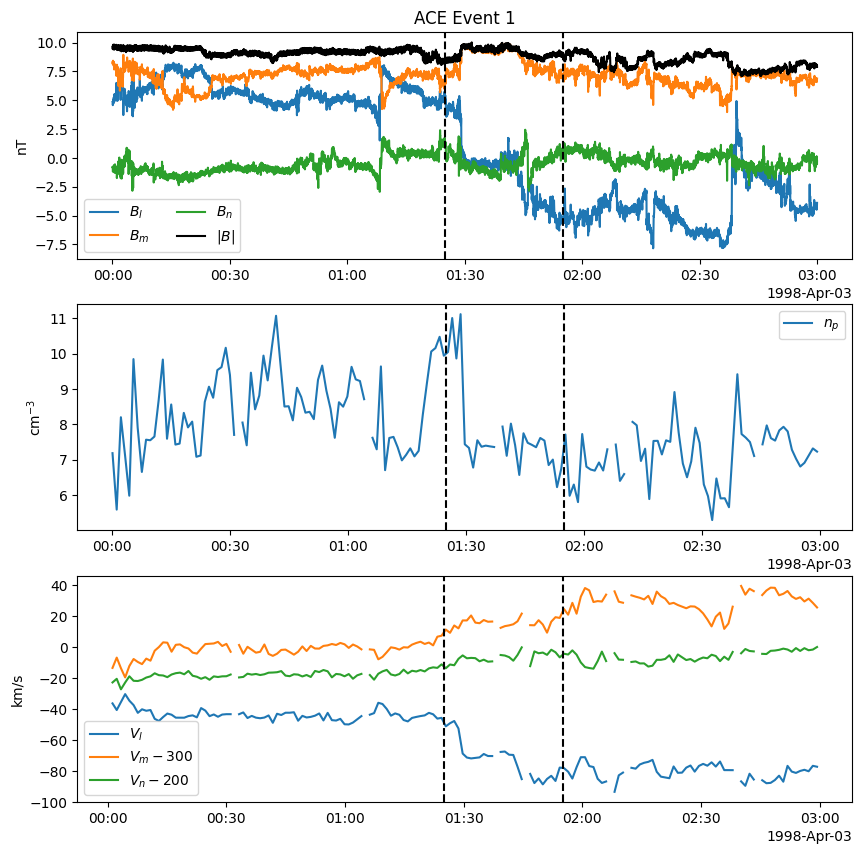

In [8]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")

axs[2].plot(nproton_datetime, vl_lmn, label=r'$V_l$')
axs[2].plot(nproton_datetime, vm_lmn-300, label=r'$V_m-300$')
axs[2].plot(nproton_datetime, vn_lmn-200, label=r'$V_n-200$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [9]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T
Vn_lmn_crossing = np.nanmean(Vr_hcs*vecn[0] + Vt_hcs*vecn[1] + Vn_hcs*vecn[2])
width_hcs = Vn_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_lmn_crossing, width_hcs))

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): 193.3; width (km): 347874.6
Vn (km/s): 325.6; width (km): 586041.1
Vn (km/s): 190.2; width (km): 342370.0


02-Sep-25 14:33:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/
02-Sep-25 14:33:13: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19980917_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19980917_v01.cdf
02-Sep-25 14:33:14: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19980917_v01.cdf


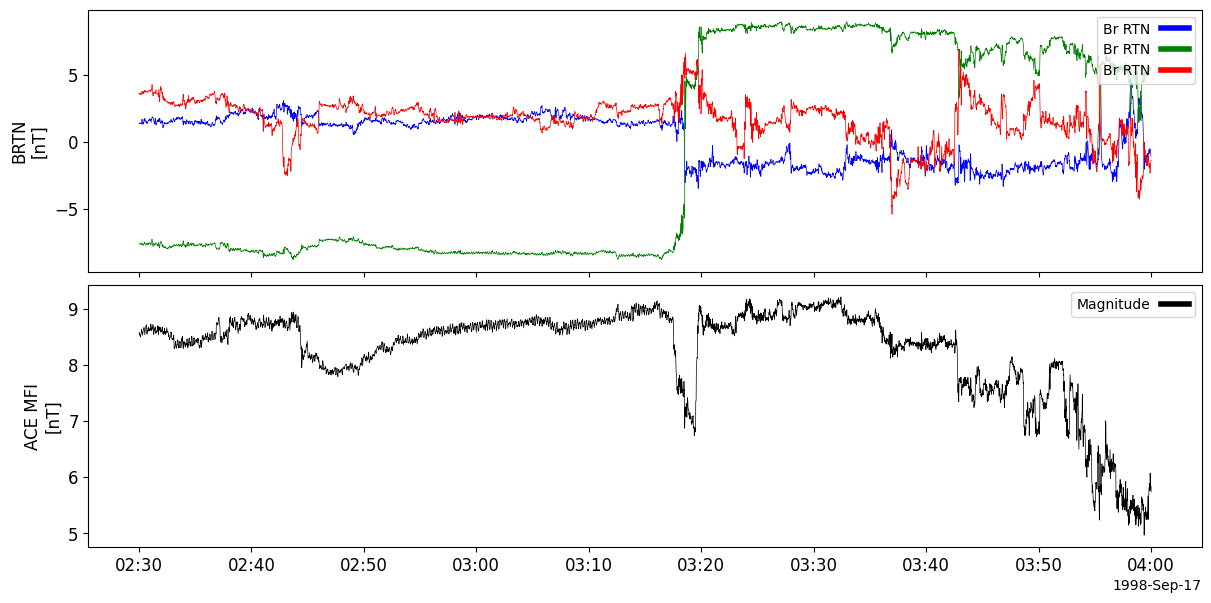

In [10]:
# ACE event 2
Event_number = 2
starttime = "1998-9-17/02:30"
endtime = "1998-9-17/04:00"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:33:18: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/
02-Sep-25 14:33:18: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19980917_v06.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19980917_v06.cdf
02-Sep-25 14:33:18: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19980917_v06.cdf
02-Sep-25 14:33:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swics/level_2_cdaweb/swi_h6/1998/
02-Sep-25 14:33:19: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swics/level_2_cdaweb/swi_h6/1998/ac_h6_swi_19980917_v03.cdf to ace_data/swics/level_2_cdaweb/swi_h6/1998/ac_h6_swi_19980917_v03.cdf
02-Sep-25 14:33:19: Download complete: ace_data/swics/level_2_cdaweb/swi_h6/1998/ac_h6_swi_19980917_v03.cdf


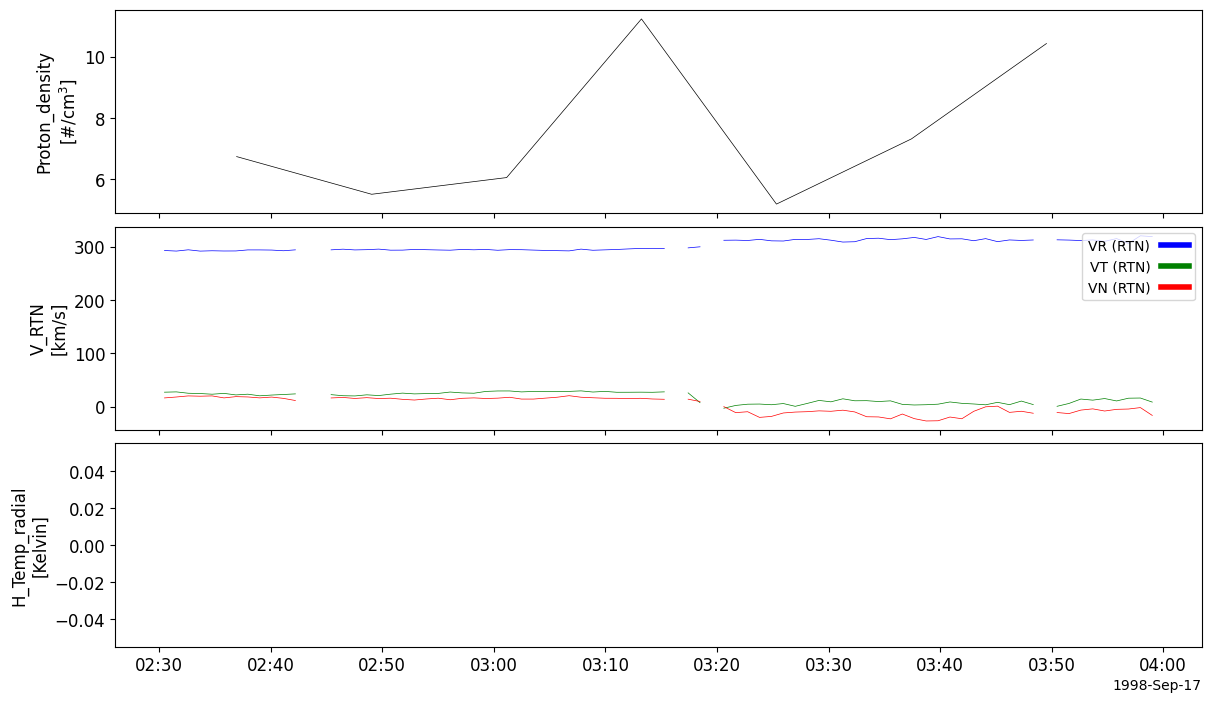

In [11]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
swics_vars = pyspedas.ace.swics(trange=[starttime, endtime], datatype='swi_h6', time_clip=True)
tplot(['nH', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('nH').times)
nproton = get_data('nH').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

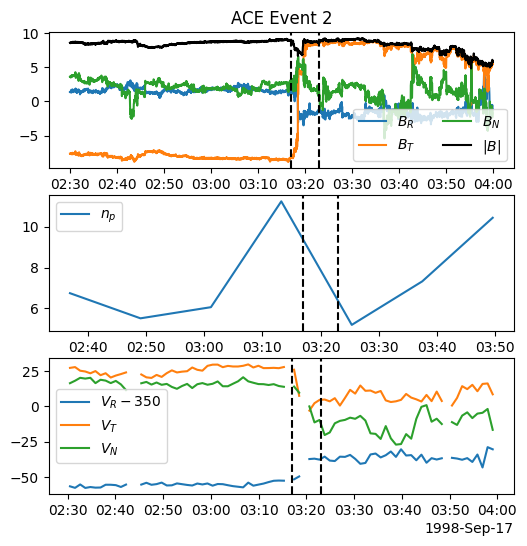

In [12]:
# HCS boundary times
B1_datetime = datetime.datetime(1998, 9, 17, 3, 17, 0)
B2_datetime = datetime.datetime(1998, 9, 17, 3, 23, 0)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(vproton_datetime, vr-350, label=r'$V_R-350$')
axs[2].plot(vproton_datetime, vt, label=r'$V_T$')
axs[2].plot(vproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [13]:
# Estimate two-sided upstream averages with 15-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=15)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=15)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('nH', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('nH', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

# if no density data
# npro_av1 = 10.0
# npro_av2 = 10.0

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  8.802656 8.859519
n_proton (/cc):  11.245 6.259
V_r (km/s):  295.265 313.895
|V| (km/s):  297.00803 314.39133


In [14]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[ 0.12734846  2.05251841 70.60923961] [[-0.94290858 -0.20016601 -0.26618975]
 [-0.26913672 -0.01285788  0.96301615]
 [ 0.19618574 -0.97967762  0.04174821]]
[[ 0.19310212 -0.98028657  0.0418308 ]
 [ 0.01764707  0.04609622  0.99878112]
 [-0.98101997 -0.19212857  0.02620046]] 159.6203597710391


Text(0, 0.5, 'km/s')

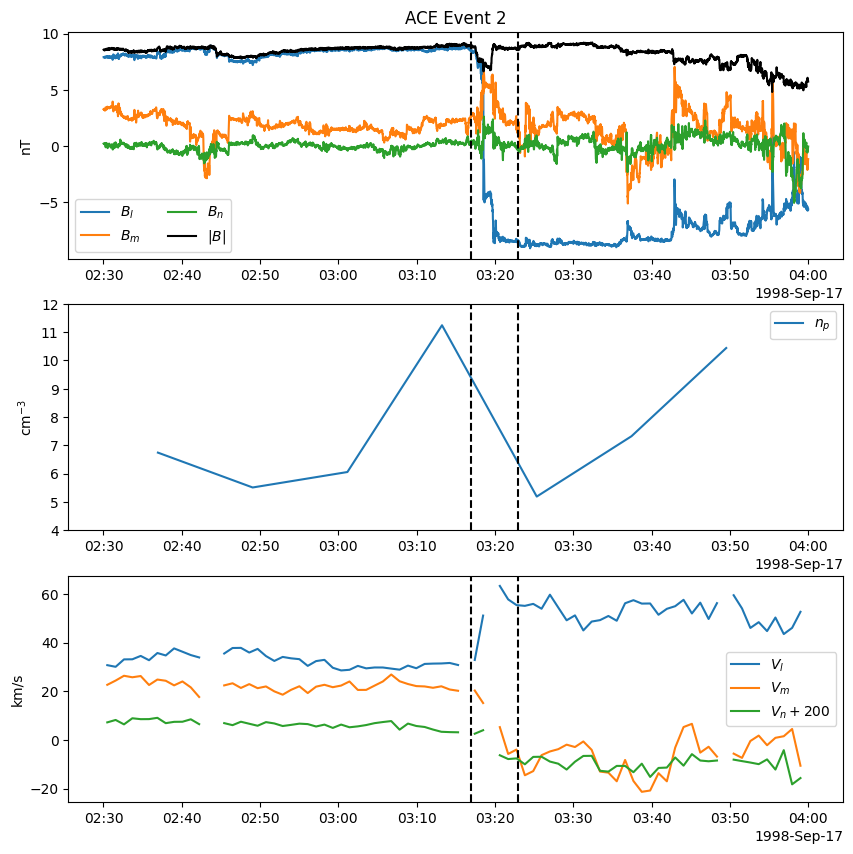

In [15]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")

axs[1].plot(fields_datetime, Bl_lmn, color='w')
axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylim(4, 12)
axs[1].set_ylabel(r"cm$^{-3}$")

axs[2].plot(fields_datetime, Bl_lmn*0, color='w')
axs[2].plot(vproton_datetime, vl_lmn, label=r'$V_l$')
axs[2].plot(vproton_datetime, vm_lmn, label=r'$V_m$')
axs[2].plot(vproton_datetime, vn_lmn+300, label=r'$V_n+200$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [16]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): -285.5; width (km): -102771.9
Vn (km/s): -297.2; width (km): -107004.3


02-Sep-25 14:34:15: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/
02-Sep-25 14:34:16: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19981123_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19981123_v01.cdf
02-Sep-25 14:34:17: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19981123_v01.cdf


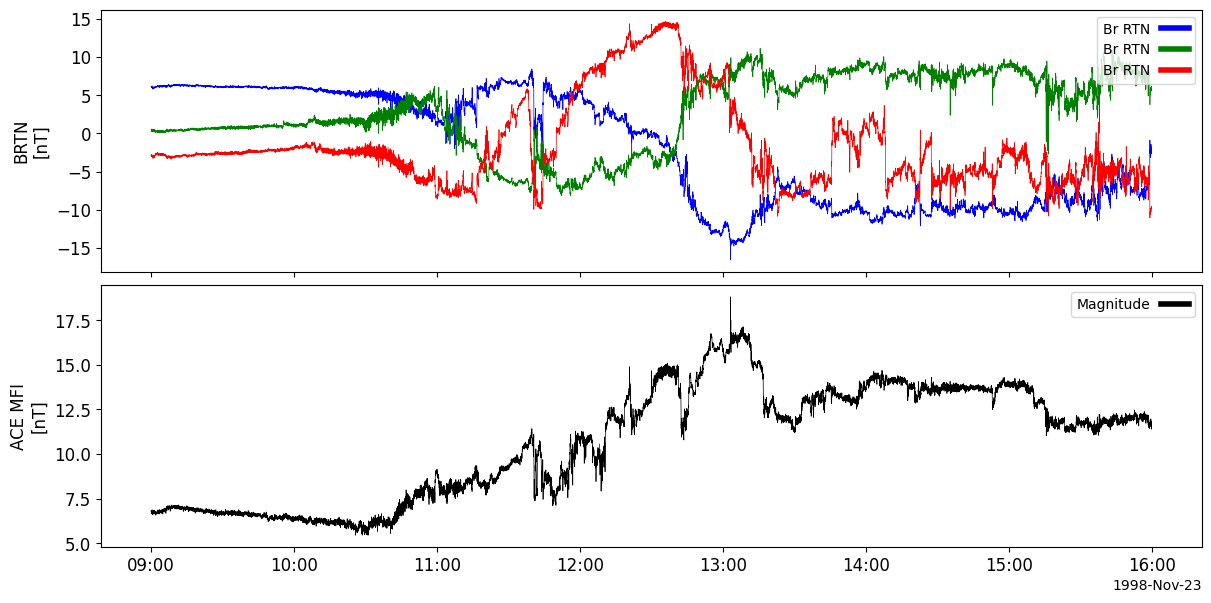

In [17]:
# ACE event 3
Event_number = 3
starttime = "1998-11-23/09:00"
endtime = "1998-11-23/16:00"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:34:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/
02-Sep-25 14:34:20: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19981123_v06.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19981123_v06.cdf
02-Sep-25 14:34:20: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19981123_v06.cdf


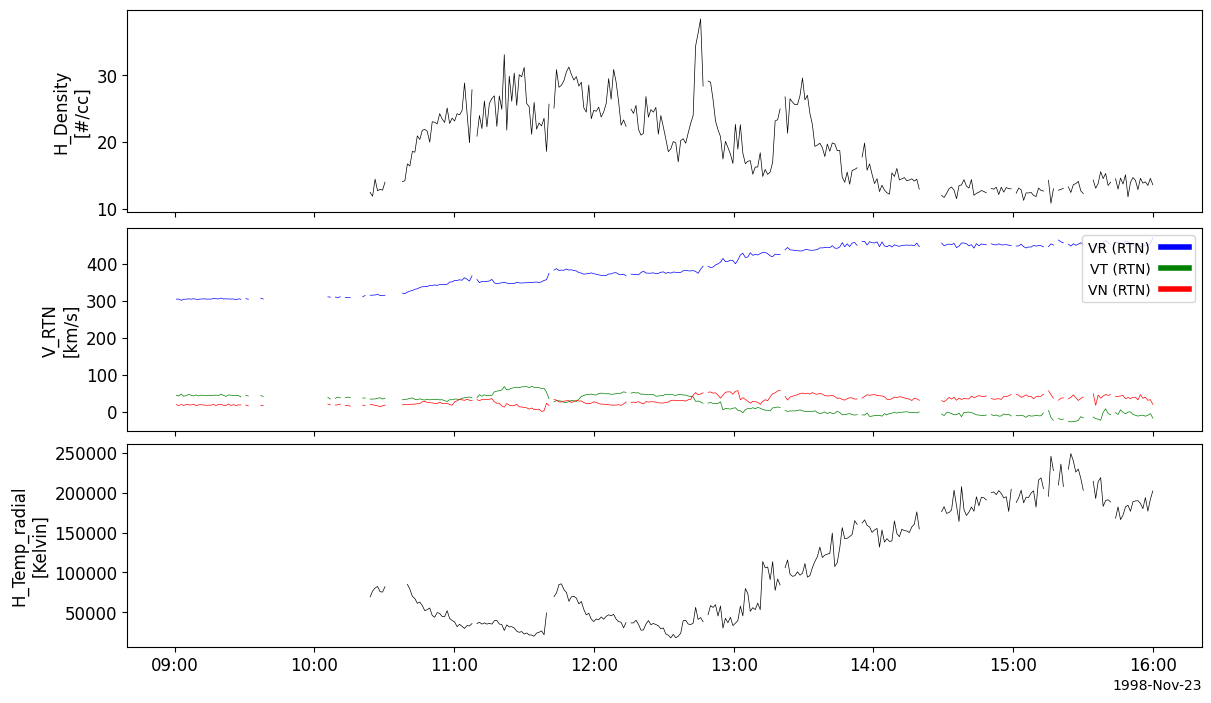

In [18]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
tplot(['Np', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

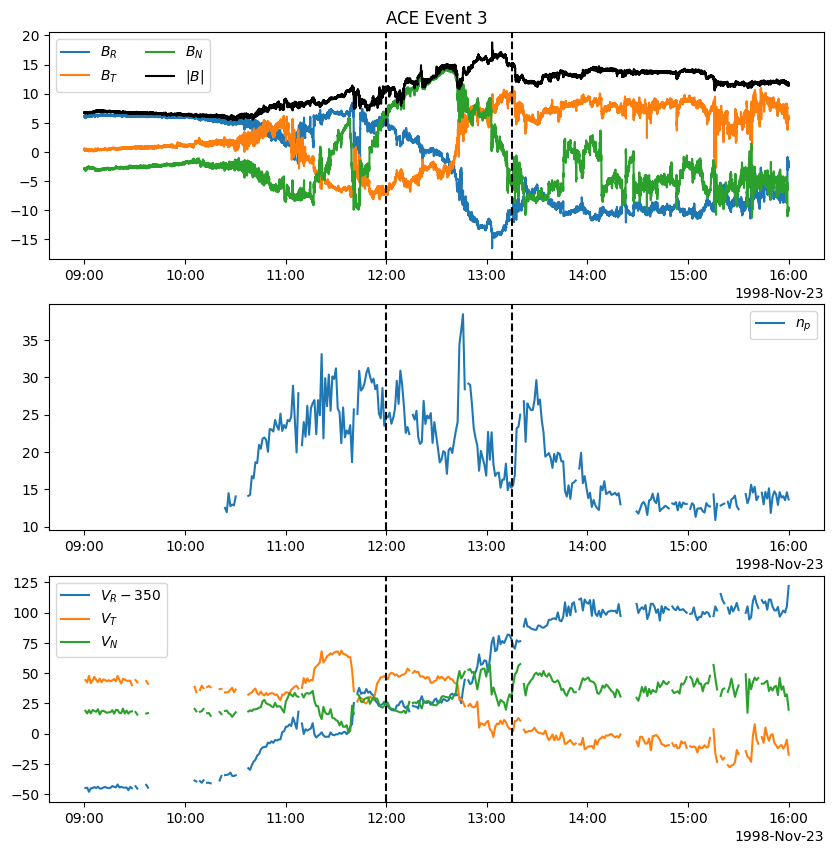

In [19]:
# HCS boundary times
B1_datetime = datetime.datetime(1998, 11, 23, 12, 0, 0)
B2_datetime = datetime.datetime(1998, 11, 23, 13, 15, 0)

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].tick_params('x', labelbottom=True)

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].tick_params('x', labelbottom=True)

axs[2].plot(nproton_datetime, vr-350, label=r'$V_R-350$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [20]:
# Estimate two-sided upstream averages with 30-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=30)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=30)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('Np', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  9.382296 12.726245
n_proton (/cc):  26.467974 22.412247
V_r (km/s):  369.91135 437.72272
|V| (km/s):  373.73636 440.1855


In [21]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[ 0.73370328 43.33632757 96.09340388] [[ 0.62621821  0.76912195  0.12768001]
 [-0.46289345  0.2350015   0.85469524]
 [-0.62735988  0.59432796 -0.50318373]]
[[-0.66350219  0.56505055 -0.49039038]
 [-0.14781387  0.54352924  0.82627297]
 [ 0.73342746  0.62072039 -0.27711052]] 148.65003777524475


Text(0, 0.5, 'km/s')

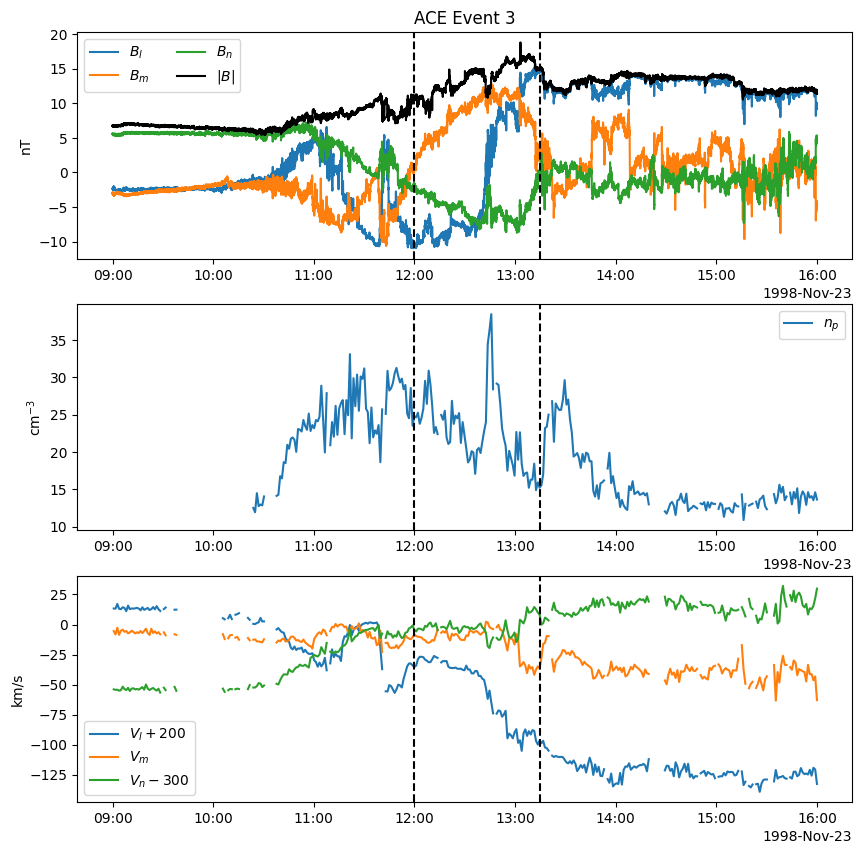

In [22]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")
axs[0].tick_params('x', labelbottom=True)

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")
axs[1].tick_params('x', labelbottom=True)

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn, label=r'$V_m$')
axs[2].plot(nproton_datetime, vn_lmn-300, label=r'$V_n-300$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [23]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T
Vn_lmn_crossing = np.nanmean(Vr_hcs*vecn[0] + Vt_hcs*vecn[1] + Vn_hcs*vecn[2])
width_hcs = Vn_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_lmn_crossing, width_hcs))

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn[0] + Vt_sc_hcs*vecn[1] + Vn_sc_hcs*vecn[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): 297.5; width (km): 1338669.8
Vn (km/s): 278.9; width (km): 1254872.5


02-Sep-25 14:34:53: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/
02-Sep-25 14:34:54: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19981225_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19981225_v01.cdf
02-Sep-25 14:34:54: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/1998/ac_h3_mfi_19981225_v01.cdf


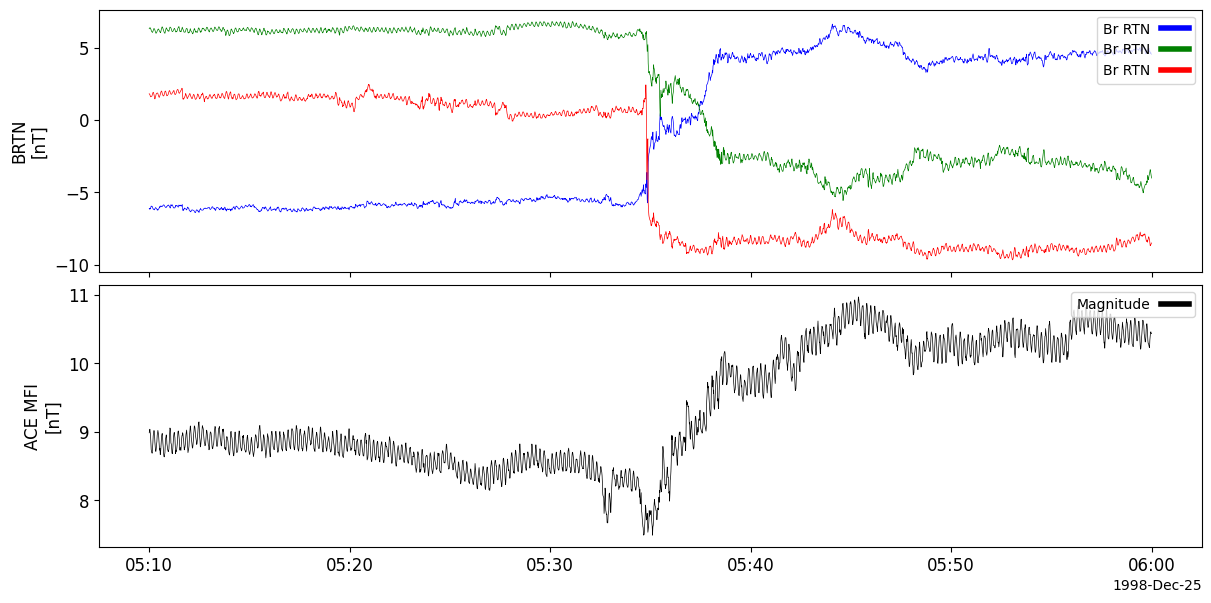

In [24]:
# ACE event 4
Event_number = 4
starttime = "1998-12-25/05:10"
endtime = "1998-12-25/06:00"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:34:59: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/
02-Sep-25 14:34:59: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19981225_v06.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19981225_v06.cdf
02-Sep-25 14:34:59: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/1998/ac_h0_swe_19981225_v06.cdf


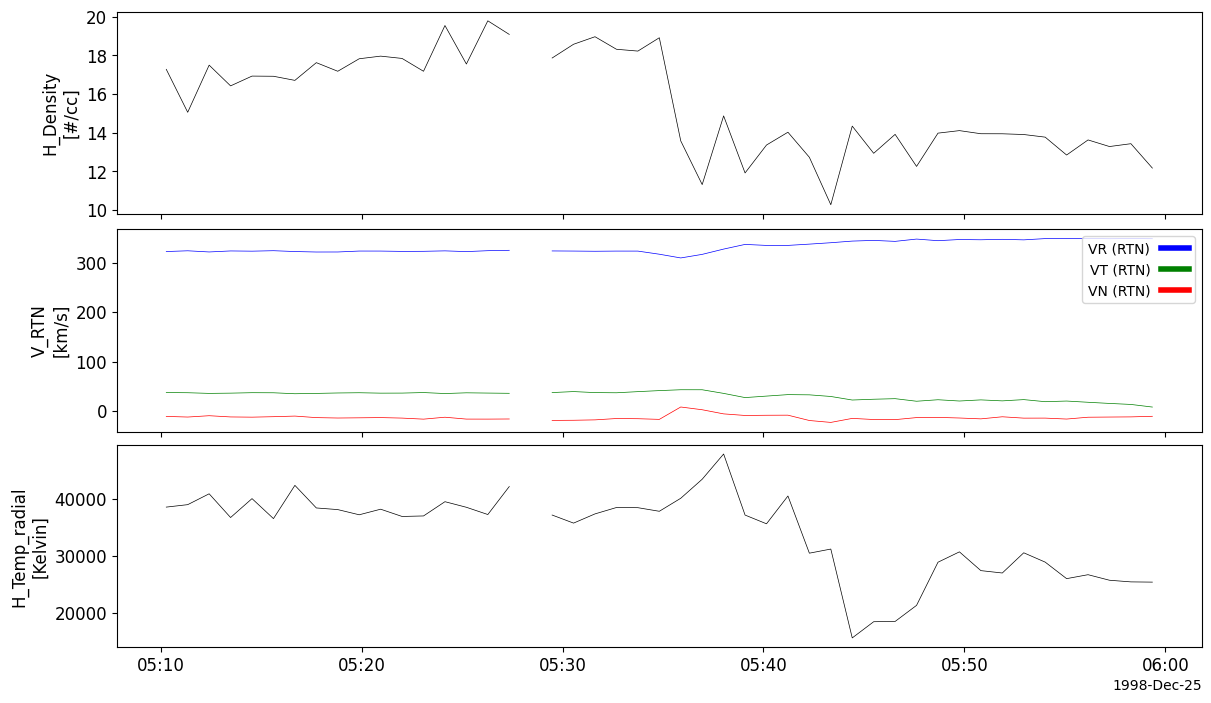

In [25]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
tplot(['Np', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

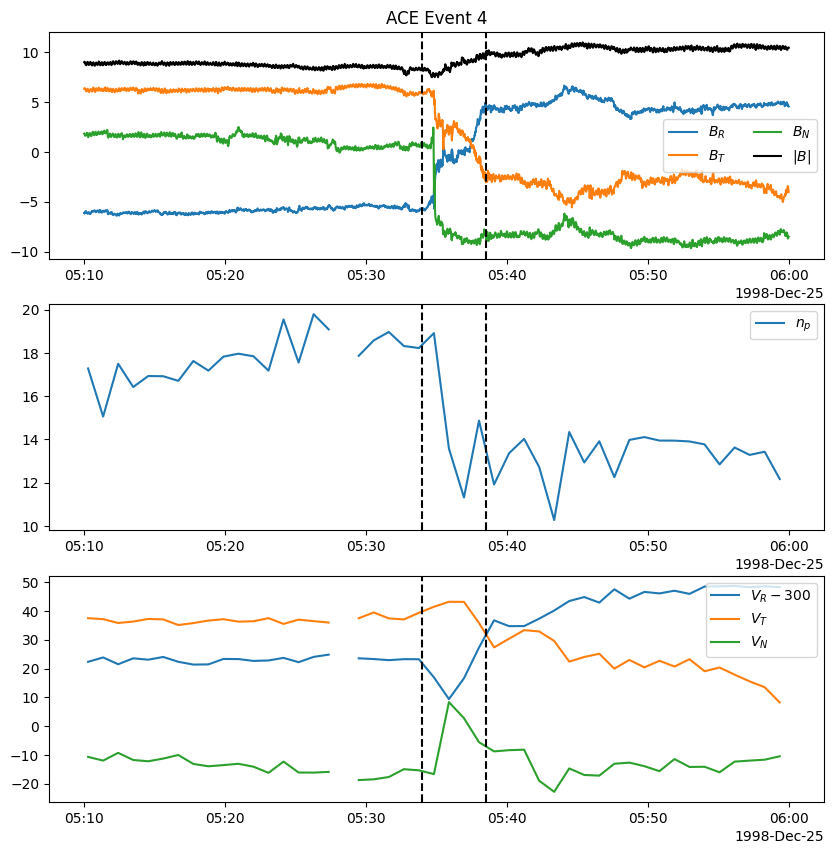

In [26]:
# HCS boundary times
B1_datetime = datetime.datetime(1998, 12, 25, 5, 34, 0)
B2_datetime = datetime.datetime(1998, 12, 25, 5, 38, 30)

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].tick_params('x', labelbottom=True)

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].tick_params('x', labelbottom=True)

axs[2].plot(nproton_datetime, vr-300, label=r'$V_R-300$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [27]:
# Estimate two-sided upstream averages with 20-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=20)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=20)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('Np', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  8.618425 10.29978
n_proton (/cc):  18.001629 13.291379
V_r (km/s):  323.06766 343.92444
|V| (km/s):  325.51038 345.05005


In [28]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[6.57920677e-02 1.43802316e+00 6.82092756e+01] [[ 0.72182125  0.68144683  0.12084826]
 [ 0.32534247 -0.48822976  0.8098049 ]
 [-0.6108407   0.54521732  0.57411821]]
[[-0.61069909  0.54534402  0.57414851]
 [-0.29218727  0.51870792 -0.80347289]
 [-0.7359845  -0.65843904 -0.15743187]] 129.7460002659954


Text(0, 0.5, 'km/s')

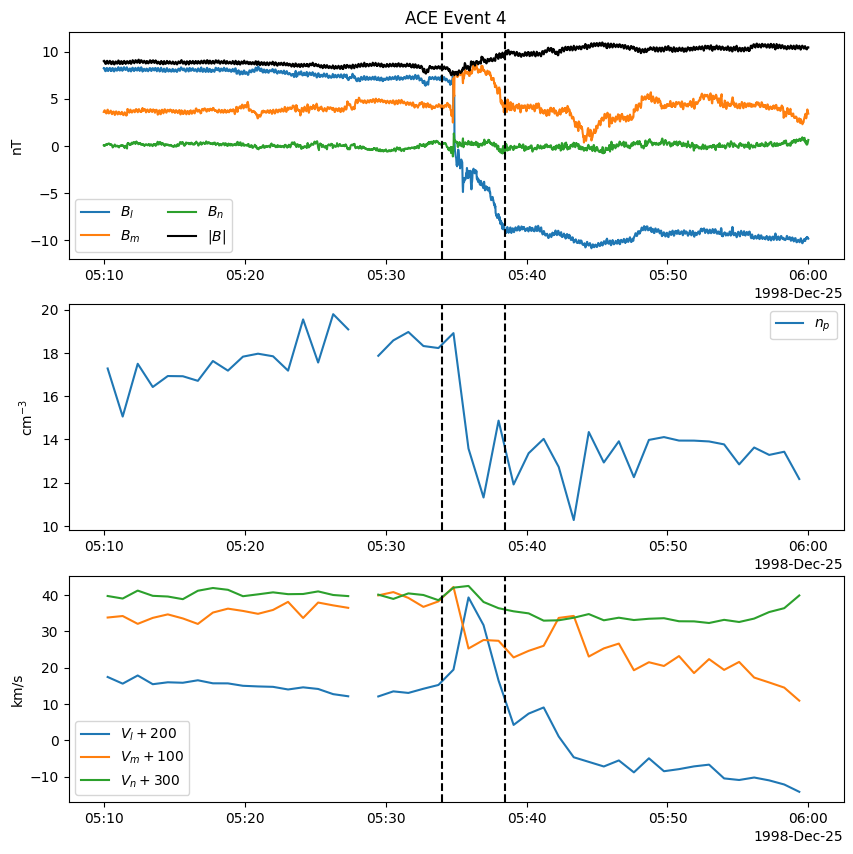

In [29]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")
axs[0].tick_params('x', labelbottom=True)

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")
axs[1].tick_params('x', labelbottom=True)

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn+100, label=r'$V_m+100$')
axs[2].plot(nproton_datetime, vn_lmn+300, label=r'$V_n+300$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [30]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): 236.3; width (km): 63802.0
Vn (km/s): -240.4; width (km): -64921.2


02-Sep-25 14:35:40: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1999/
02-Sep-25 14:35:40: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/1999/ac_h3_mfi_19990426_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/1999/ac_h3_mfi_19990426_v01.cdf
02-Sep-25 14:35:41: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/1999/ac_h3_mfi_19990426_v01.cdf


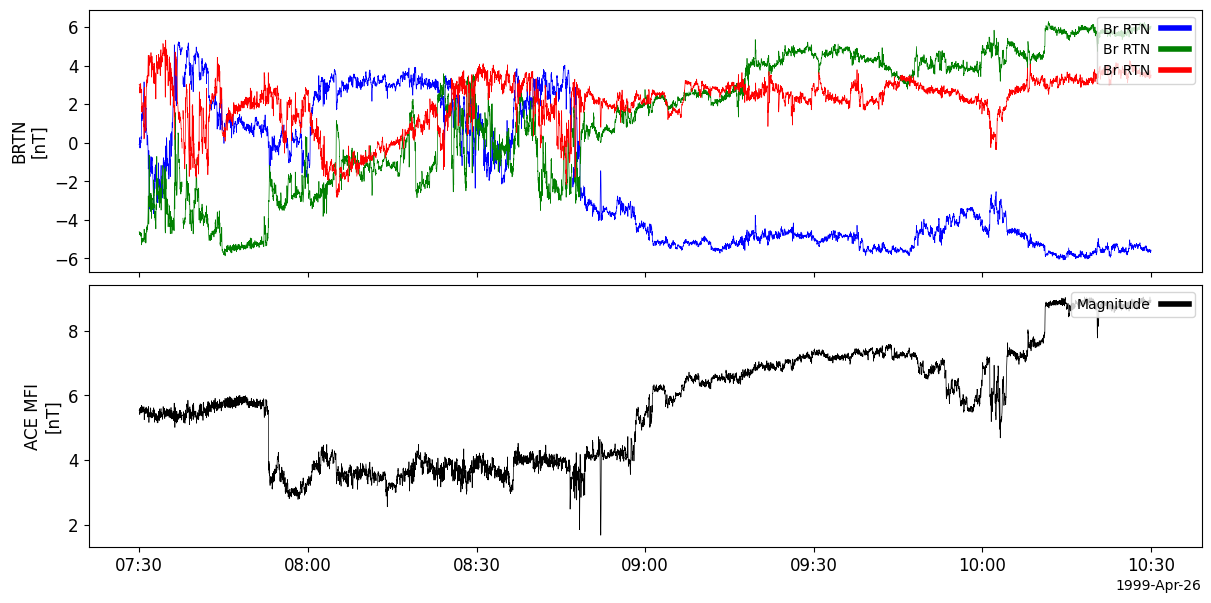

In [31]:
# ACE event 5
Event_number = 5
starttime = "1999-4-26/07:30"
endtime = "1999-4-26/10:30"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:35:45: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1999/
02-Sep-25 14:35:45: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/1999/ac_h0_swe_19990426_v06.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/1999/ac_h0_swe_19990426_v06.cdf
02-Sep-25 14:35:45: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/1999/ac_h0_swe_19990426_v06.cdf


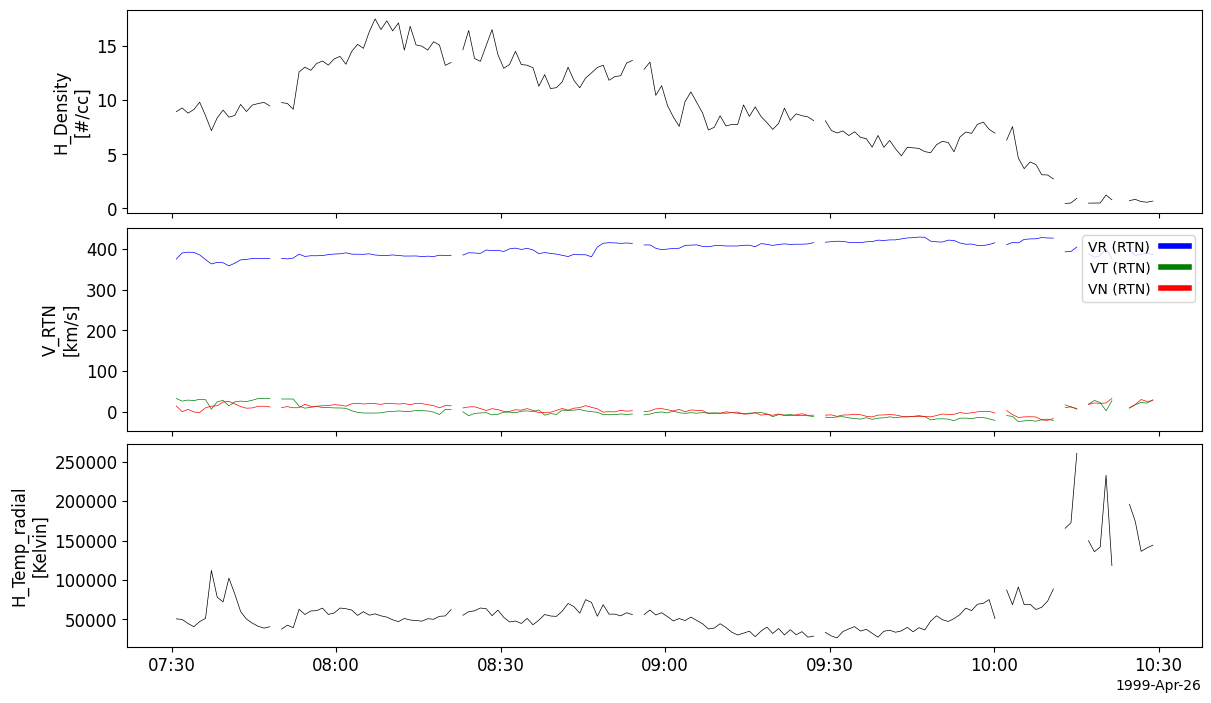

In [32]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
tplot(['Np', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

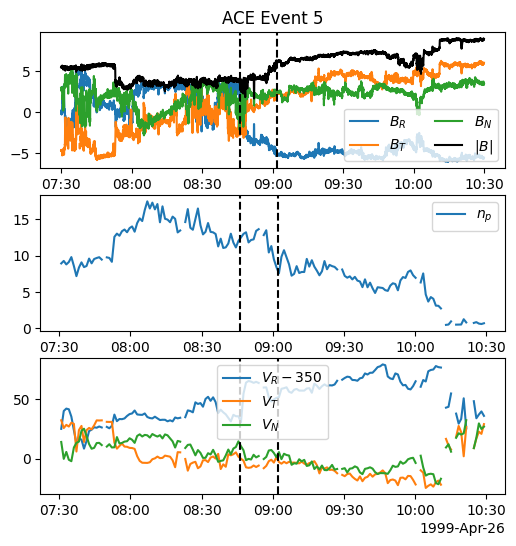

In [33]:
# HCS boundary times
# B1_datetime = datetime.datetime(1999, 4, 26, 7, 53, 0)  # include partial crossings
B1_datetime = datetime.datetime(1999, 4, 26, 8, 46, 0)
B2_datetime = datetime.datetime(1999, 4, 26, 9, 2, 0)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-350, label=r'$V_R-350$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [34]:
# Estimate two-sided upstream averages with 45-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=45)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=45)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('Np', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  3.7208798 6.865464
n_proton (/cc):  14.177907 7.577385
V_r (km/s):  388.52658 414.08865
|V| (km/s):  388.7777 414.29416


In [35]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[ 1.06421685  1.44195142 18.1776711 ] [[ 0.29329107  0.07872094  0.95277666]
 [ 0.44854694  0.86877288 -0.20985551]
 [-0.84426654  0.4889138   0.21949329]]
[[-0.84151311  0.49491651  0.21659486]
 [-0.37917439 -0.25550007 -0.88935173]
 [-0.38481486 -0.83052838  0.40266633]] 128.51142991313728


Text(0, 0.5, 'km/s')

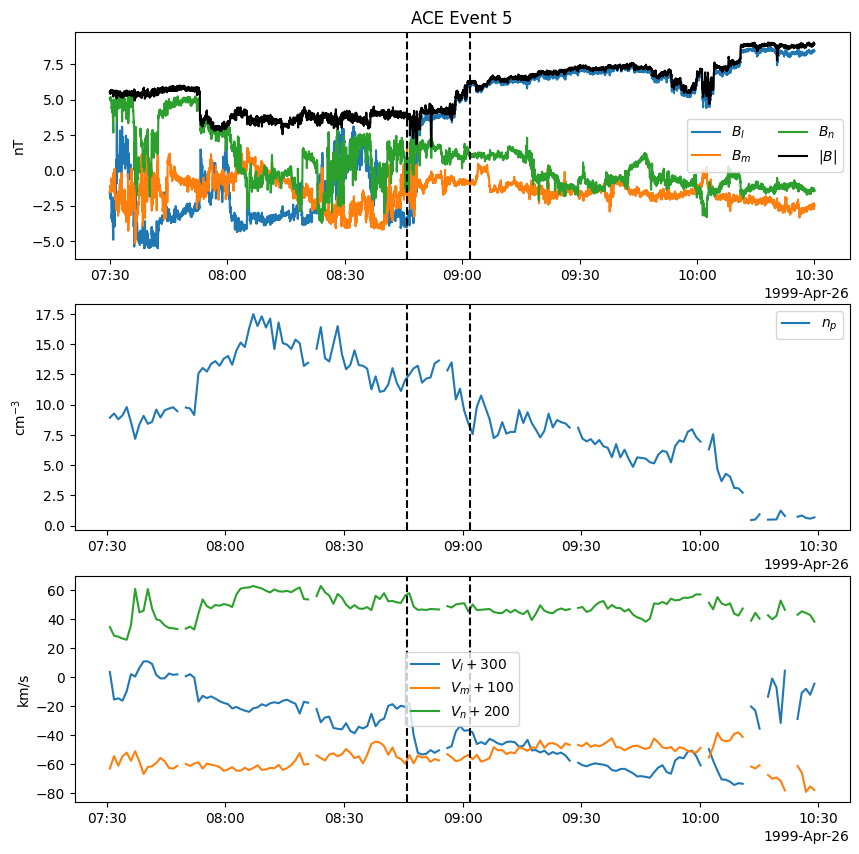

In [36]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")

axs[2].plot(nproton_datetime, vl_lmn+300, label=r'$V_l+300$')
axs[2].plot(nproton_datetime, vm_lmn+100, label=r'$V_m+100$')
axs[2].plot(nproton_datetime, vn_lmn+200, label=r'$V_n+200$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [37]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): 119.6; width (km): 114813.8
Vn (km/s): -126.7; width (km): -121627.4


02-Sep-25 14:36:24: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2003/
02-Sep-25 14:36:25: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2003/ac_h3_mfi_20030626_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/2003/ac_h3_mfi_20030626_v01.cdf
02-Sep-25 14:36:25: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/2003/ac_h3_mfi_20030626_v01.cdf


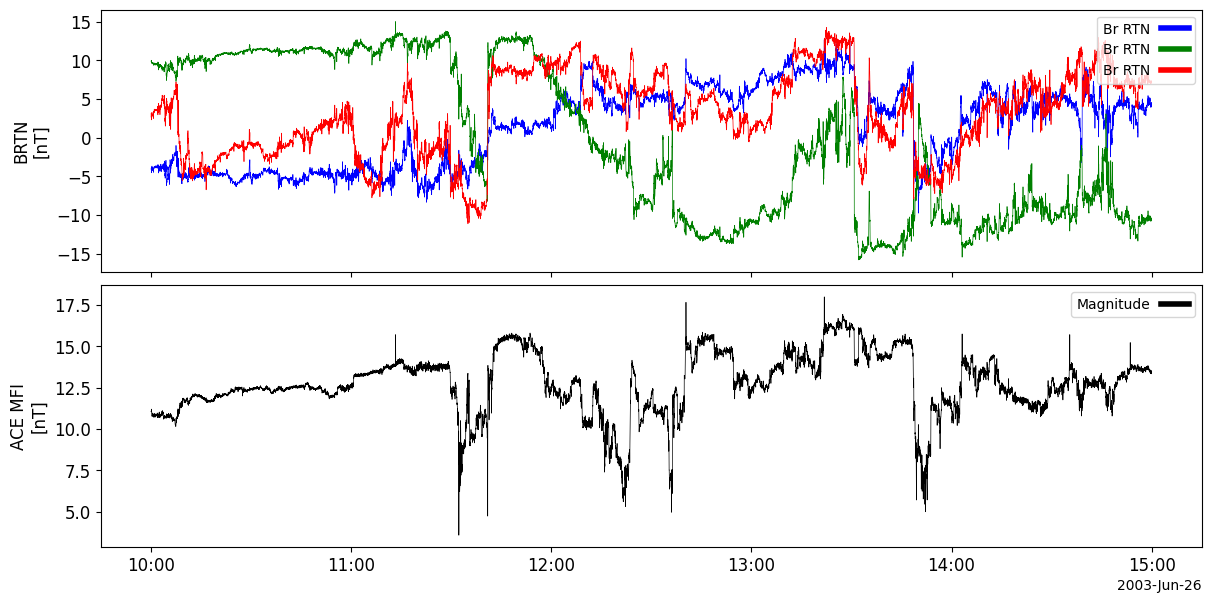

In [38]:
# ACE event 6
Event_number = 6
starttime = "2003-6-26/10:00"
endtime = "2003-6-26/15:00"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:36:42: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2003/
02-Sep-25 14:36:43: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2003/ac_h0_swe_20030626_v06.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/2003/ac_h0_swe_20030626_v06.cdf
02-Sep-25 14:36:43: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/2003/ac_h0_swe_20030626_v06.cdf


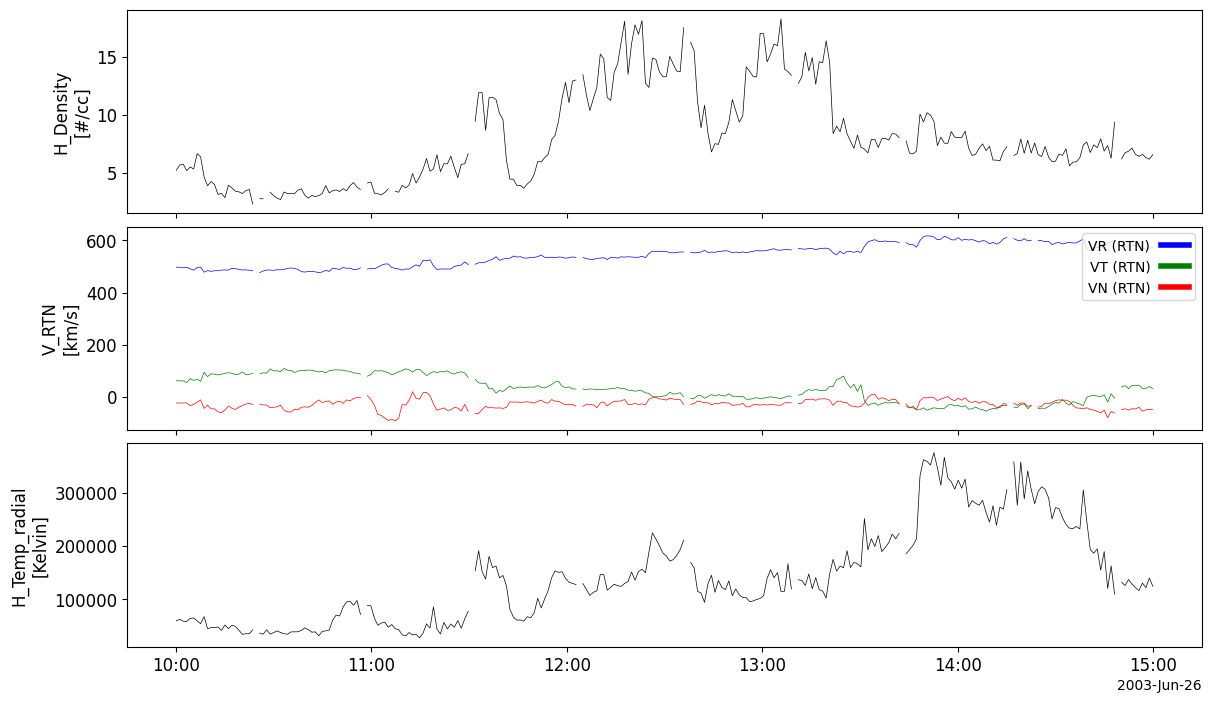

In [39]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
tplot(['Np', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

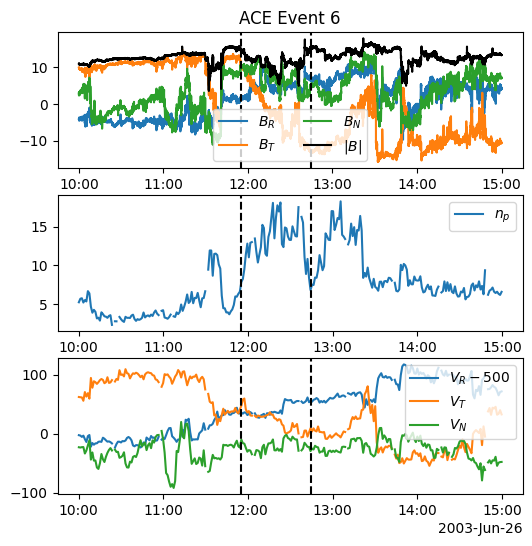

In [40]:
# HCS boundary times
B1_datetime = datetime.datetime(2003, 6, 26, 11, 55, 0)
B2_datetime = datetime.datetime(2003, 6, 26, 12, 45, 0)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-500, label=r'$V_R-500$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [41]:
# Estimate two-sided upstream averages with 60-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=60)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=60)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('Np', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  13.238173 14.472463
n_proton (/cc):  5.7536263 11.144404
V_r (km/s):  511.71426 567.5547
|V| (km/s):  519.364 568.75745


In [42]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[  2.52338038  42.14159169 107.89752463] [[ 0.81062124  0.26960528 -0.51981363]
 [ 0.45458088  0.26983875  0.8488482 ]
 [-0.36911981  0.92439172 -0.09617962]]
[[-0.3675195   0.92489892 -0.09742384]
 [ 0.52707764  0.2934495   0.79754408]
 [ 0.76623666  0.24176309 -0.59534198]] 144.20290160664948


Text(0, 0.5, 'km/s')

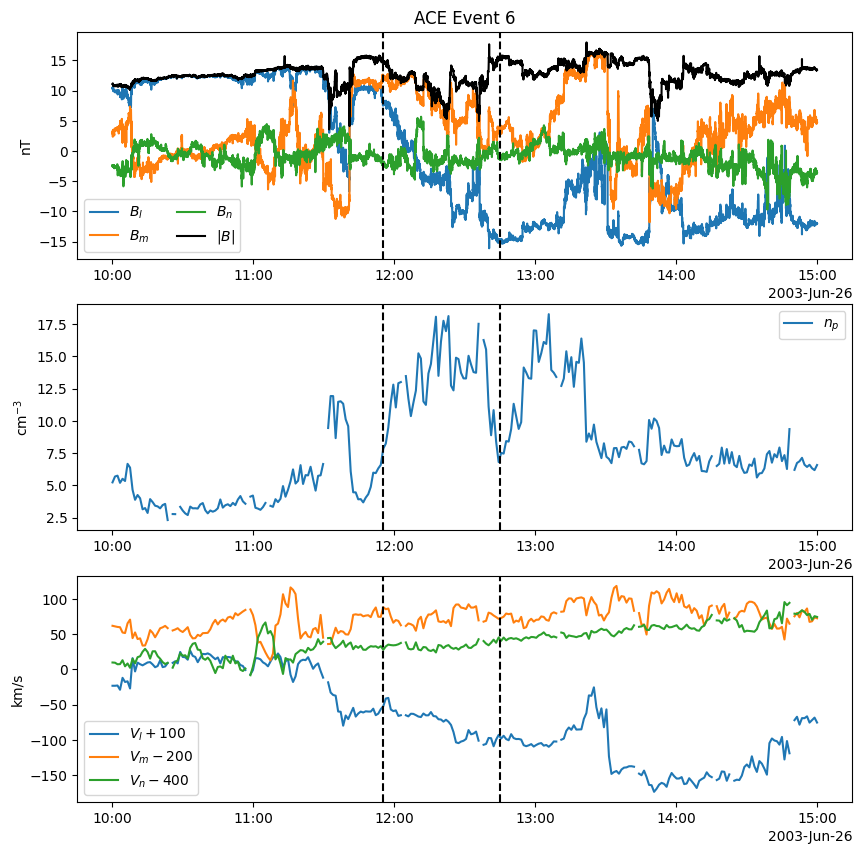

In [43]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")

axs[2].plot(nproton_datetime, vl_lmn+100, label=r'$V_l+100$')
axs[2].plot(nproton_datetime, vm_lmn-200, label=r'$V_m-200$')
axs[2].plot(nproton_datetime, vn_lmn-400, label=r'$V_n-400$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [44]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): 448.1; width (km): 1344344.8
Vn (km/s): 425.9; width (km): 1277663.9


02-Sep-25 14:37:28: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2003/
02-Sep-25 14:37:28: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2003/ac_h3_mfi_20031205_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/2003/ac_h3_mfi_20031205_v01.cdf
02-Sep-25 14:37:29: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/2003/ac_h3_mfi_20031205_v01.cdf


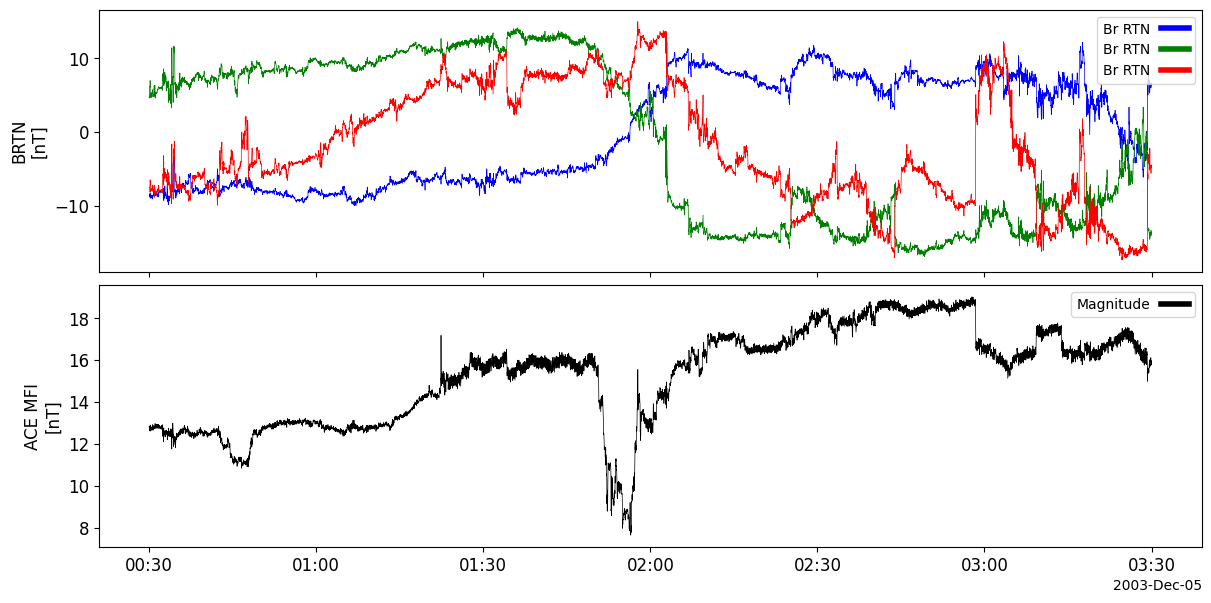

In [45]:
# ACE event 7
Event_number = 7
starttime = "2003-12-5/00:30"
endtime = "2003-12-5/03:30"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:37:32: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2003/
02-Sep-25 14:37:32: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2003/ac_h0_swe_20031205_v07.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/2003/ac_h0_swe_20031205_v07.cdf
02-Sep-25 14:37:33: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/2003/ac_h0_swe_20031205_v07.cdf
02-Sep-25 14:37:33: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swics/level_2_cdaweb/swi_h6/2003/
02-Sep-25 14:37:33: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swics/level_2_cdaweb/swi_h6/2003/ac_h6_swi_20031205_v03.cdf to ace_data/swics/level_2_cdaweb/swi_h6/2003/ac_h6_swi_20031205_v03.cdf
02-Sep-25 14:37:33: Download complete: ace_data/swics/level_2_cdaweb/swi_h6/2003/ac_h6_swi_20031205_v03.cdf


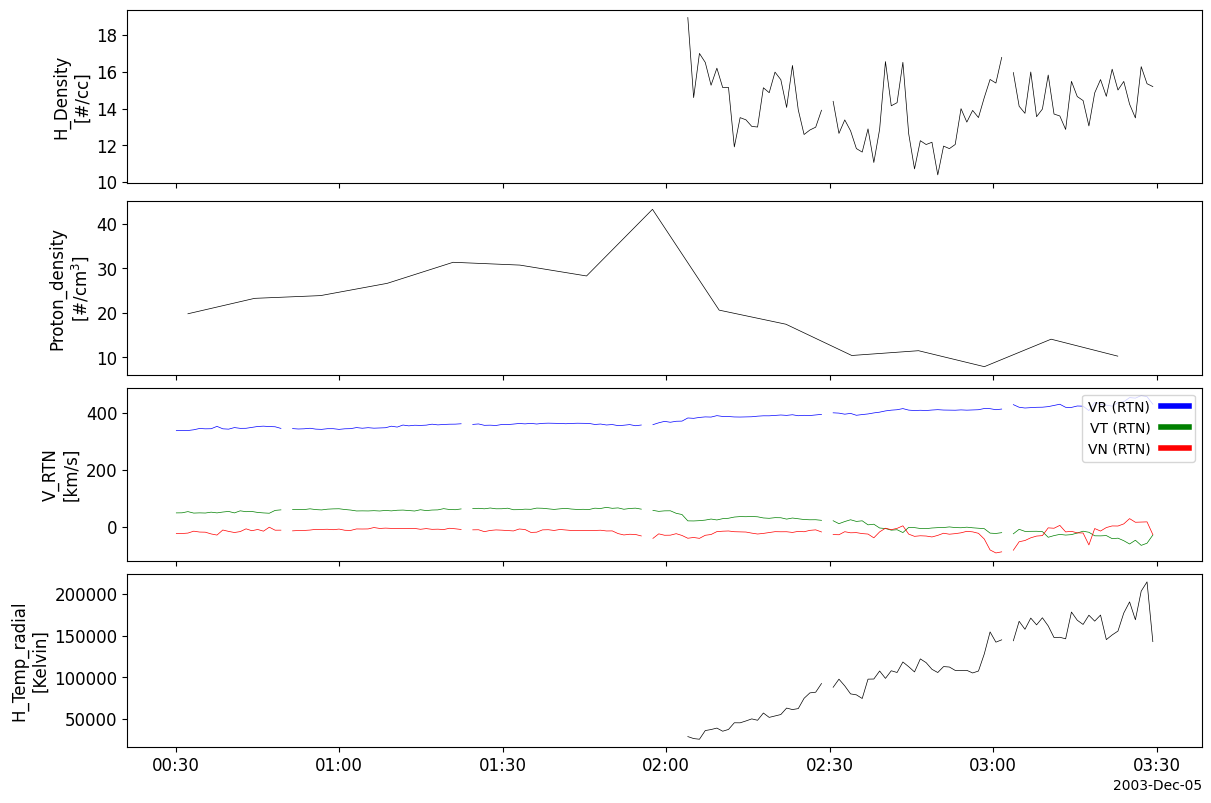

In [46]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
swics_vars = pyspedas.ace.swics(trange=[starttime, endtime], datatype='swi_h6', time_clip=True)
tplot(['Np', 'nH', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
nH_datetime = pyspedas.time_datetime(get_data('nH').times)
nH = get_data('nH').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

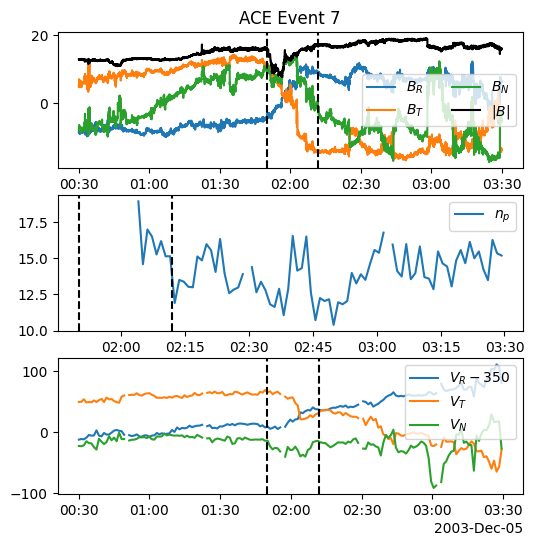

In [47]:
# HCS boundary times
B1_datetime = datetime.datetime(2003, 12, 5, 1, 50, 0)
B2_datetime = datetime.datetime(2003, 12, 5, 2, 12, 0)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-350, label=r'$V_R-350$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [48]:
# Estimate two-sided upstream averages with 60-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=60)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=60)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('nH', dtime_pre1, dtime_pre2,
                   newname='nH_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('nH_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)    # pre-HCS density from SWICS
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  14.3164015 17.49683
n_proton (/cc):  28.1578 13.665651
V_r (km/s):  355.5047 404.31763
|V| (km/s):  360.96423 406.19156


In [49]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[  2.60722123  35.44451704 206.38492251] [[ 0.79923158  0.55790623 -0.22353863]
 [ 0.37952507 -0.1800846   0.90748568]
 [-0.46603604  0.81012973  0.3556687 ]]
[[-0.46409465  0.81178153  0.35443885]
 [-0.55962065  0.0414595  -0.8277112 ]
 [-0.68661553 -0.58248764  0.43504858]] 172.77210758395208


Text(0, 0.5, 'km/s')

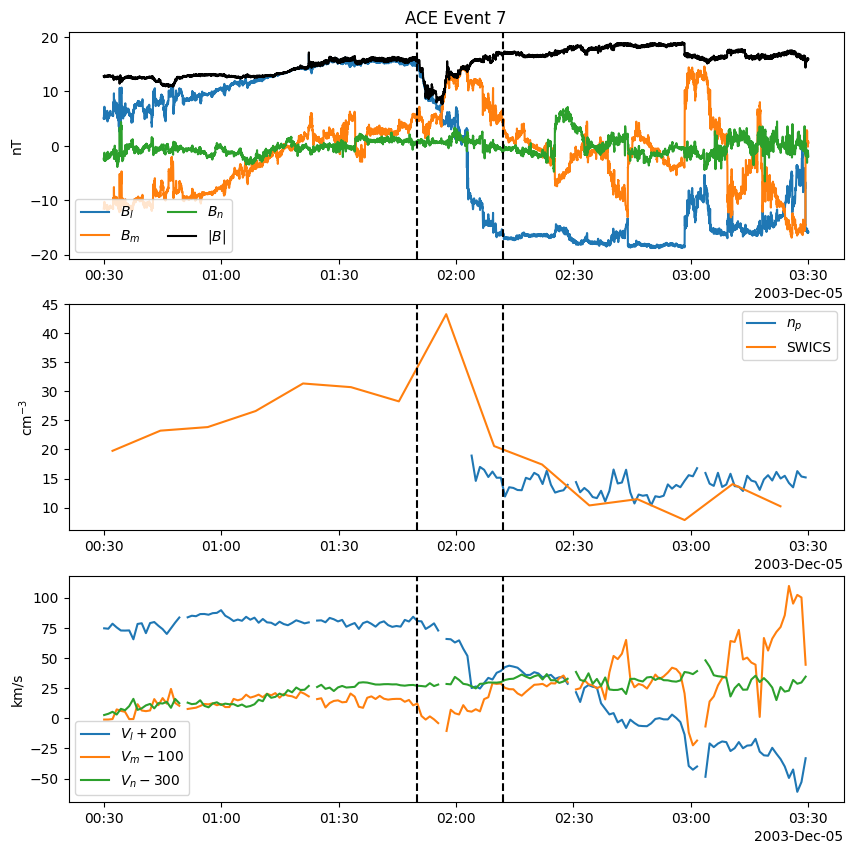

In [50]:
# plot in lmn coordinates
# Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]    # use cross product
# Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
# Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
# vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
# vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
# vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

Bl_lmn = Br*vecl0[0] + Bt*vecl0[1] + Bn*vecl0[2]    # use MVA
Bm_lmn = Br*vecm0[0] + Bt*vecm0[1] + Bn*vecm0[2]
Bn_lmn = Br*vecn0[0] + Bt*vecn0[1] + Bn*vecn0[2]
vl_lmn = vr*vecl0[0] + vt*vecl0[1] + vn*vecl0[2]
vm_lmn = vr*vecm0[0] + vt*vecm0[1] + vn*vecm0[2]
vn_lmn = vr*vecn0[0] + vt*vecn0[1] + vn*vecn0[2]

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")
axs[0].tick_params('x', labelbottom=True)

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].plot(nH_datetime, nH, label='SWICS')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")
axs[1].tick_params('x', labelbottom=True)

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn-100, label=r'$V_m-100$')
axs[2].plot(nproton_datetime, vn_lmn-300, label=r'$V_n-300$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [51]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): 311.8; width (km): 411550.4
Vn (km/s): -276.0; width (km): -364312.5


02-Sep-25 14:38:33: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2004/
02-Sep-25 14:38:33: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2004/ac_h3_mfi_20041010_v01.cdf to ace_data/mag/level_2_cdaweb/mfi_h3/2004/ac_h3_mfi_20041010_v01.cdf
02-Sep-25 14:38:34: Download complete: ace_data/mag/level_2_cdaweb/mfi_h3/2004/ac_h3_mfi_20041010_v01.cdf


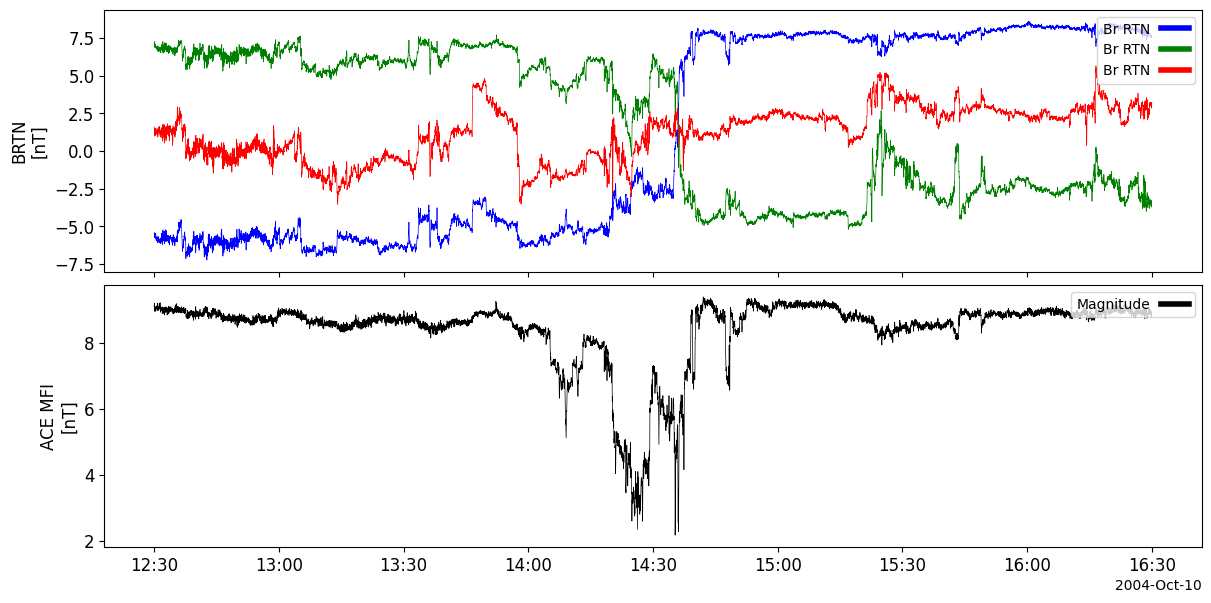

In [52]:
# ACE event 8
Event_number = 8
starttime = "2004-10-10/12:30"
endtime = "2004-10-10/16:30"

mfi_vars = pyspedas.ace.mfi(trange=[starttime, endtime], time_clip=True)
tplot(['BRTN', 'Magnitude'])
fields_datetime = pyspedas.time_datetime(get_data('BRTN').times)
Br, Bt, Bn = get_data('BRTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

02-Sep-25 14:38:39: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2004/
02-Sep-25 14:38:39: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2004/ac_h0_swe_20041010_v07.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/2004/ac_h0_swe_20041010_v07.cdf
02-Sep-25 14:38:39: Download complete: ace_data/swepam/level_2_cdaweb/swe_h0/2004/ac_h0_swe_20041010_v07.cdf


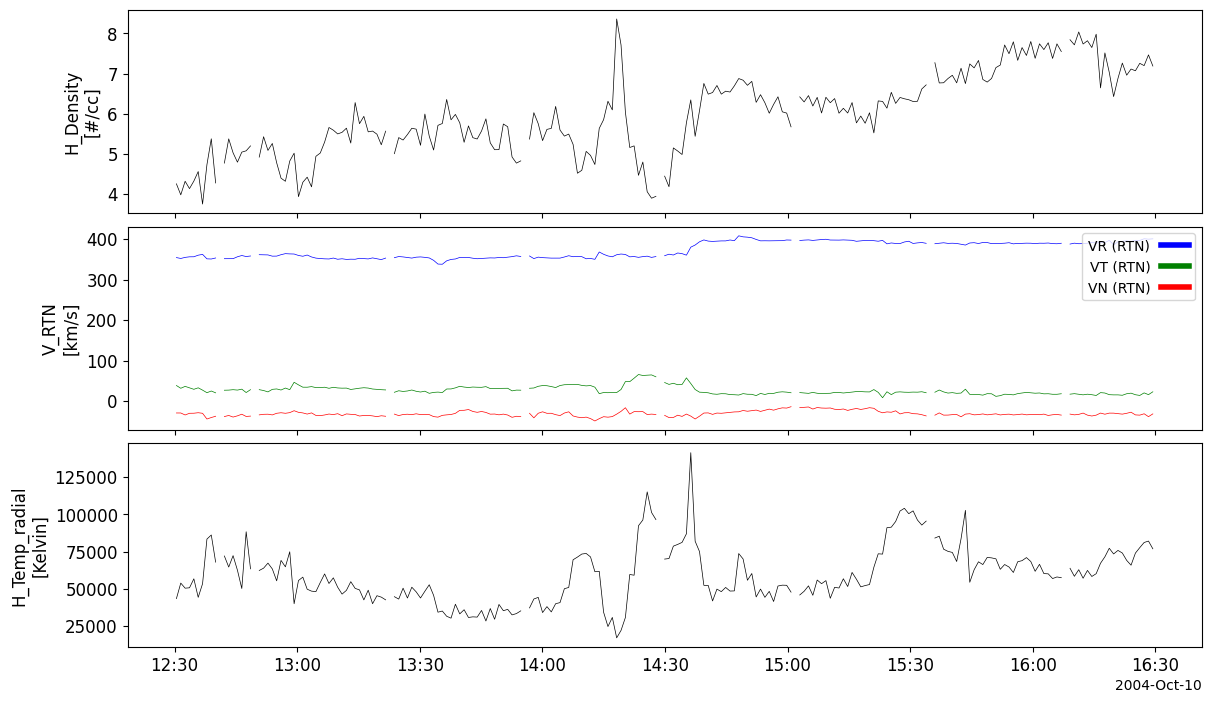

In [53]:
swe_vars = pyspedas.ace.swe(trange=[starttime, endtime], time_clip=True)
tplot(['Np', 'V_RTN', 'Tpr'])
nproton_datetime = pyspedas.time_datetime(get_data('Np').times)
nproton = get_data('Np').y
vproton_datetime = pyspedas.time_datetime(get_data('V_RTN').times)
vr, vt, vn = get_data('V_RTN').y.T

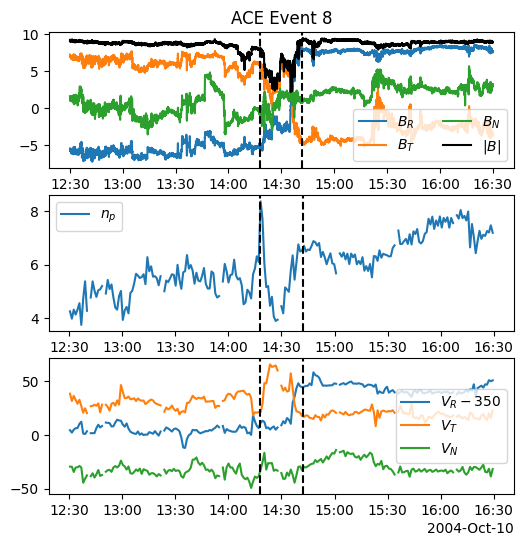

In [54]:
# HCS boundary times
# B1_datetime = datetime.datetime(2004, 10, 10, 13, 55, 0)
# B2_datetime = datetime.datetime(2004, 10, 10, 14, 40, 0)
B1_datetime = datetime.datetime(2004, 10, 10, 14, 18, 0)
B2_datetime = datetime.datetime(2004, 10, 10, 14, 42, 0)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-350, label=r'$V_R-350$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [55]:
# Estimate two-sided upstream averages with 60-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=60)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=60)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('BRTN', dtime_pre1, dtime_pre2,
                   newname='BRTN_pre')
pyspedas.time_clip('BRTN', dtime_post1, dtime_post2,
                   newname='BRTN_post')

Br1, Bt1, Bn1 = get_data('BRTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('BRTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.nanmean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('Np', dtime_pre1, dtime_pre2,
                   newname='Np_pre')
pyspedas.time_clip('Np', dtime_post1, dtime_post2,
                   newname='Np_post')
npro1 = get_data('Np_pre').y
npro2 = get_data('Np_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('V_RTN', dtime_pre1, dtime_pre2,
                   newname='V_RTN_pre')
pyspedas.time_clip('V_RTN', dtime_post1, dtime_post2,
                   newname='V_RTN_post')

Vr1, Vt1, Vn1 = get_data('V_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('V_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  8.367169 8.799129
n_proton (/cc):  5.4714794 6.369468
V_r (km/s):  353.70413 395.39816
|V| (km/s):  356.73523 396.71643


In [56]:
# find lmn coordinates with MVA
pyspedas.time_clip('BRTN', dtime_pre1, dtime_post2,
                   newname='BRTN_mva')
Br_m, Bt_m, Bn_m = get_data('BRTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)
vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

[ 0.20816178  3.05763087 60.32005137] [[-0.53804465 -0.58959631  0.60239866]
 [ 0.27485397  0.55288214  0.78662357]
 [ 0.79684581 -0.58881026  0.13542239]]
[[ 0.79559378 -0.58995159  0.13779574]
 [-0.4262322  -0.70670524 -0.56470685]
 [ 0.4305307   0.3905443  -0.8137067 ]] 151.05291198563359


Text(0, 0.5, 'km/s')

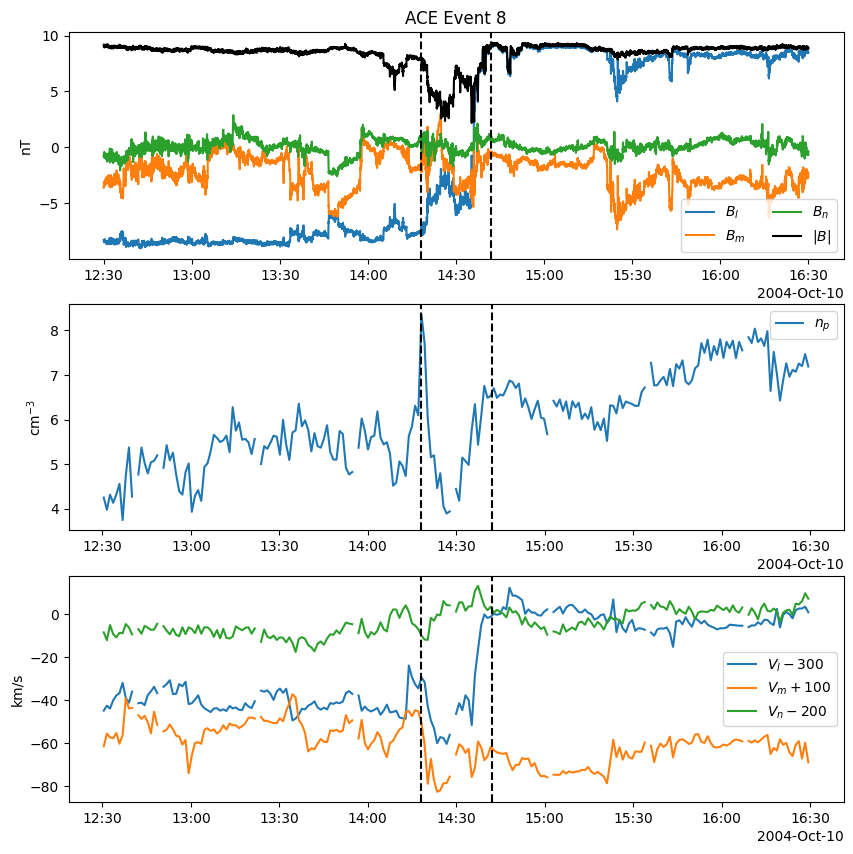

In [57]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("ACE Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")

axs[2].plot(nproton_datetime, vl_lmn-300, label=r'$V_l-300$')
axs[2].plot(nproton_datetime, vm_lmn+100, label=r'$V_m+100$')
axs[2].plot(nproton_datetime, vn_lmn-200, label=r'$V_n-200$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/A%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

In [58]:
# calculate thickness with HCS velocity
pyspedas.time_clip('V_RTN', dtime_pre2, dtime_post1,
                   newname='V_RTN_inhcs')

Vr_hcs, Vt_hcs, Vn_hcs = get_data('V_RTN_inhcs').y.T

# estimate spacecraft velocity by Vt - 30 km/s
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = Vr_hcs, Vt_hcs - 30.0, Vn_hcs
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

Vn (km/s): -225.2; width (km): -324265.8
Vn (km/s): 190.0; width (km): 273609.6
